# 0. 라이브러리 불러오기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 1. 이미지 불러오기

Invalid SOS parameters for sequential JPEG


(4000, 3000, 3)
(4032, 3024, 3)


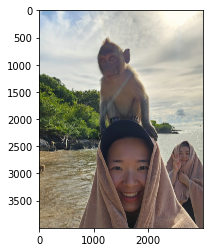

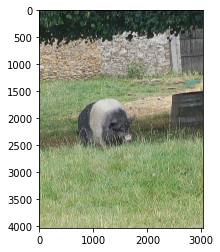

In [3]:
me_path = '나.png'  
me_orig = cv2.imread(me_path)
pig_path = '돼지.jpg'  
pig_orig = cv2.imread(pig_path)

print(me_orig.shape)
print(pig_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(me_orig, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(pig_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 모델 준비

In [4]:
model_dir = os.getenv('HOME')
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7e48d796c610>)

In [5]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [6]:
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues_me, output_me = model.segmentAsPascalvoc(me_path)
segvalues_pig, output_pig = model.segmentAsPascalvoc(pig_path)

In [7]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

# 3. 마스크 만들기

(4000, 3000)


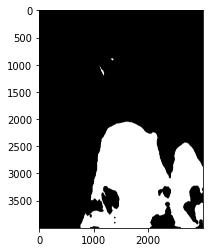

In [8]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

me_seg_map = np.all(output_me==seg_color, axis=-1) 
print(me_seg_map.shape) 
plt.imshow(me_seg_map, cmap='gray')
plt.show()

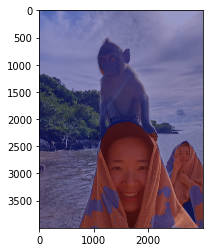

In [9]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
me_show = me_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
me_mask = me_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
me_color_mask = cv2.applyColorMap(me_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
me_show = cv2.addWeighted(me_show, 0.6, me_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(me_show, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 배경 흐리게 하기

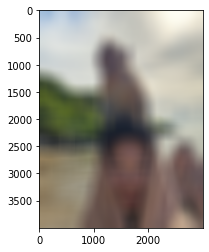

In [10]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
# => (300, 300)으로 변경하여 블러를 더 세게 넣었음
me_orig_blur = cv2.blur(me_orig, (300,300))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(me_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

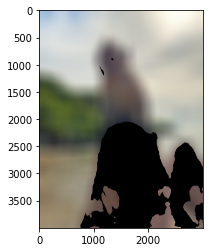

In [11]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
me_mask_color = cv2.cvtColor(me_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
me_bg_mask = cv2.bitwise_not(me_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
me_bg_blur = cv2.bitwise_and(me_orig_blur, me_bg_mask)
plt.imshow(cv2.cvtColor(me_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 5. 흐린 배경과 원본 합성

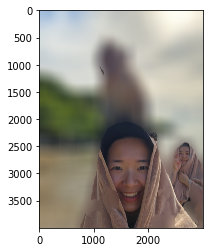

In [12]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
me_concat = np.where(me_mask_color==255, me_orig, me_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(me_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제 1.

- **문제:** 친구가 남아버렸음... 나만 살리고 싶음.   
- **요구 사항:** 전처리를 통해서 친구를 없애자!   
- **해결 방안:** 세그멘테이션 결과에서 "가장 큰 사람"만 남기기   
- **상세 방안:**   
    1) me_seg_map에서 윤곽선 찾기 (cv2.findContours)   
    2) 윤곽선 중 가장 면적 큰 것만 남김   
    3) 그걸 마스크로 써서 앞사람만 남기고 나머지는 블러 처리   

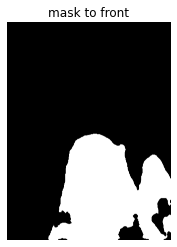

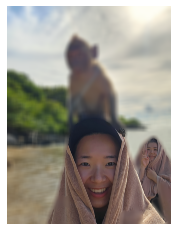

In [13]:
# 1. 마스크 윤곽선 찾기
contours, _ = cv2.findContours(me_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 2. 가장 면적 큰 contour 찾기
largest_contour = max(contours, key=cv2.contourArea)

# 3. 앞사람 마스크 만들기
me_front_mask = np.zeros_like(me_mask)
cv2.drawContours(me_front_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# 시각화 (앞사람 마스크)
plt.imshow(me_front_mask, cmap='gray')
plt.title("mask to front")
plt.axis('off')
plt.show()

# 4. 블러 적용 (더 강하게)
me_orig_blur = cv2.blur(me_orig, (100, 100))

# 5. 마스크 3채널로 변환
me_front_mask_color = cv2.cvtColor(me_front_mask, cv2.COLOR_GRAY2BGR)
me_bg_mask = cv2.bitwise_not(me_front_mask_color)

# 6. 앞사람 제외하고 배경 블러 처리
me_bg_blur = cv2.bitwise_and(me_orig_blur, me_bg_mask)

# 7. 최종 합성
me_concat = np.where(me_front_mask_color == 255, me_orig, me_bg_blur)

# 8. 결과 시각화
plt.imshow(cv2.cvtColor(me_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 문제 1-2.

여전히 친구가 남음.    
친구와 내가 하나의 개체로 인식됐을 가능성이 큼.

- **해결 방안:** cv2.connectedComponentsWithStates() 를 써서 분리된 사람 객체 각각을 따로 분류하기

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50526 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47564 missing from current font.
  font.set_

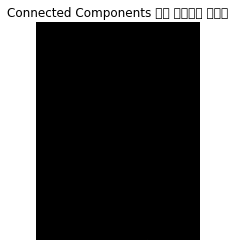

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_

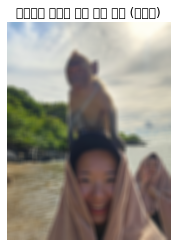

In [14]:
# 연결된 구성 요소 분석 (사람 각각 분리)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(me_mask)

# 0번은 배경 -> 제외하고 y 좌표가 가장 큰 객체 찾기
max_y = -1
target_label = 0

for i in range(1, num_labels):  # 0번은 배경
    x, y, w, h, area = stats[i]
    cy = centroids[i][1]  # 중심 y좌표
    if cy > max_y:
        max_y = cy
        target_label = i

# 앞사람 마스크 생성
me_front_mask = np.uint8((labels == target_label) * 255)

# 시각화 확인
plt.imshow(me_front_mask, cmap='gray')
plt.title("Connected Components 기반 앞사람만 마스크")
plt.axis('off')
plt.show()

# 이후 블러 처리 동일
me_orig_blur = cv2.blur(me_orig, (100, 100))
me_front_mask_color = cv2.cvtColor(me_front_mask, cv2.COLOR_GRAY2BGR)
me_bg_mask = cv2.bitwise_not(me_front_mask_color)
me_bg_blur = cv2.bitwise_and(me_orig_blur, me_bg_mask)
me_concat = np.where(me_front_mask_color == 255, me_orig, me_bg_blur)

# 최종 결과
plt.imshow(cv2.cvtColor(me_concat, cv2.COLOR_BGR2RGB))
plt.title("앞사람만 남기고 배경 블러 처리 (정확히)")
plt.axis('off')
plt.show()

## 문제 1-3.

마스크가 전체 검정이 됐음.  
connectedComponents에서 사람 객체를 전혀 분리하지 못했다는 의미.   

- **why?:** me_mask에 있는 값이 정확히 255가 아니라, 흐릿한 경계가 포함되어 있어서 binary mask가 아니기 때문일 수 있음


- **해결 방안:** 입력 마스크를 확실하게 0과 255의 이진 마스크로 구분.

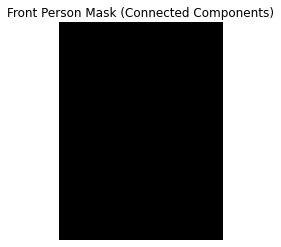

In [15]:
# 확실하게 이진 마스크로 바꾸기: 0 or 255 only
_, bin_mask = cv2.threshold(me_mask, 127, 255, cv2.THRESH_BINARY)

# 연결된 컴포넌트들
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask)

# Skip background (label 0), get component with largest center y value
max_y = -1
target_label = 0

for i in range(1, num_labels):  # label 0 = background
    cy = centroids[i][1]  # center y of the component
    if cy > max_y:
        max_y = cy
        target_label = i

# 선택된 사람 마스크 만들기
me_front_mask = np.uint8((labels == target_label) * 255)

# 결과 보기
plt.imshow(me_front_mask, cmap='gray')
plt.title("Front Person Mask (Connected Components)")
plt.axis('off')
plt.show()


## 문제 1-4.

여전히 마스크가 전체 검정.     

- **해결 방안:** 조금 더 계산적으로, 가장 아래 + 중앙에 있는 사람 blob을 거리 기반으로 잡아내기 (Contour 대신 "Distance Transform + 중심 추출")

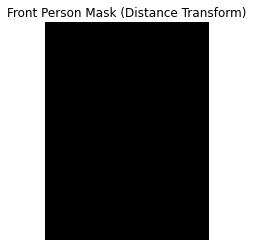

In [16]:
# 1. 이진 마스크 사용
mask_bin = (me_seg_map > 127).astype(np.uint8) * 255

# 2. Distance Transform → 중심에서 가장 멀리 떨어진 점 찾기
dist_transform = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 5)
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(dist_transform)

# maxLoc = 중심에 가까운 사람의 한 점 (x, y)
center_point = maxLoc

# 3. Contour 찾기
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. 중심점이 포함된 contour만 선택
target_contour = None
for cnt in contours:
    if cv2.pointPolygonTest(cnt, center_point, False) >= 0:
        target_contour = cnt
        break

# 5. 선택된 사람 마스크 만들기
me_front_mask = np.zeros_like(mask_bin)
if target_contour is not None:
    cv2.drawContours(me_front_mask, [target_contour], -1, 255, thickness=cv2.FILLED)

# 시각화
plt.imshow(me_front_mask, cmap='gray')
plt.title("Front Person Mask (Distance Transform)")
plt.axis('off')
plt.show()


## 문제 1 해결 포기..ㅠㅠ